In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv(r'..\stocks\TSLA.csv', index_col=['Date'], parse_dates=['Date'])
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,46.276001,43.799999,46.144001,44.681999,34135500.0,44.681999
2016-01-05,45.377998,44.000000,45.271999,44.686001,15934000.0,44.686001
2016-01-06,44.009998,43.195999,44.000000,43.807999,18895500.0,43.807999
2016-01-07,43.688000,42.734001,42.838001,43.130001,17771500.0,43.130001
2016-01-08,44.088001,42.153999,43.571999,42.200001,18140500.0,42.200001


### Data Frame ‘Company_name’, ‘Date’, ‘High’, ‘Low’, ‘Open’ ,‘Close’, ‘Volume’, ‘Adj. Close’. 
* Volume is the number of shares that changed hands (Traded) during a given day. 
* Adj closing price (used to examine historical returns) factors in anything that might affect the stock price after the market is closed.

In [3]:
df.shape

(1287, 6)

In [4]:
# Described Tesla's stock data
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1287.000000,1287.000000,1287.000000,1287.000000,1.287000e+03,1287.000000
mean,121.206190,115.741518,118.512437,118.710735,4.356612e+07,118.710735
std,163.805173,155.974267,159.952150,160.442190,3.054893e+07,160.442190
min,30.993999,28.209999,28.464001,28.733999,8.297500e+06,28.733999
25%,48.667000,46.901001,47.823999,47.761000,2.386425e+07,47.761000
50%,63.032001,60.950001,62.172001,62.043999,3.442800e+07,62.043999
75%,74.099998,71.611000,72.912003,72.659000,5.169675e+07,72.659000
max,900.400024,871.599976,891.380005,883.090027,3.046940e+08,883.090027


In [5]:
df.nunique()

High         1219
Low          1232
Open         1226
Close        1262
Volume       1283
Adj Close    1262
dtype: int64

In [6]:
#cleaning the data
#check the missing data
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

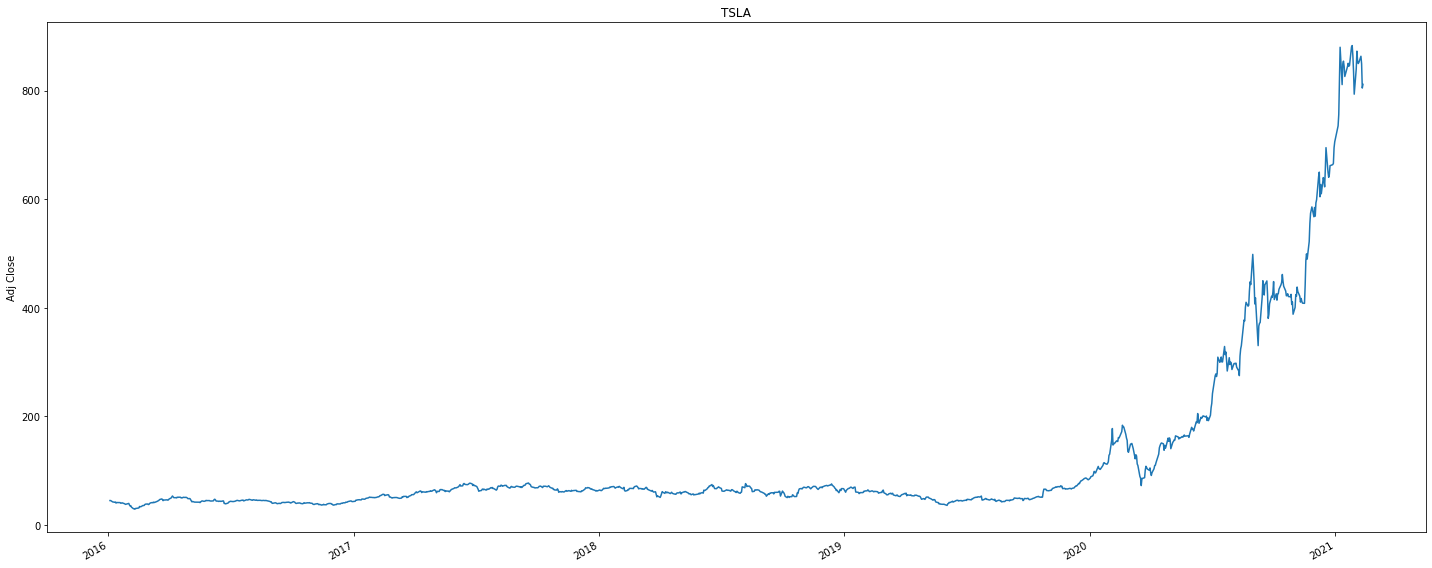

In [7]:
# To see a historical view of the closing price. For historical view I’ll be using Adj. Closing price
plt.figure(figsize=(20, 8))
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title('TSLA')
plt.tight_layout()

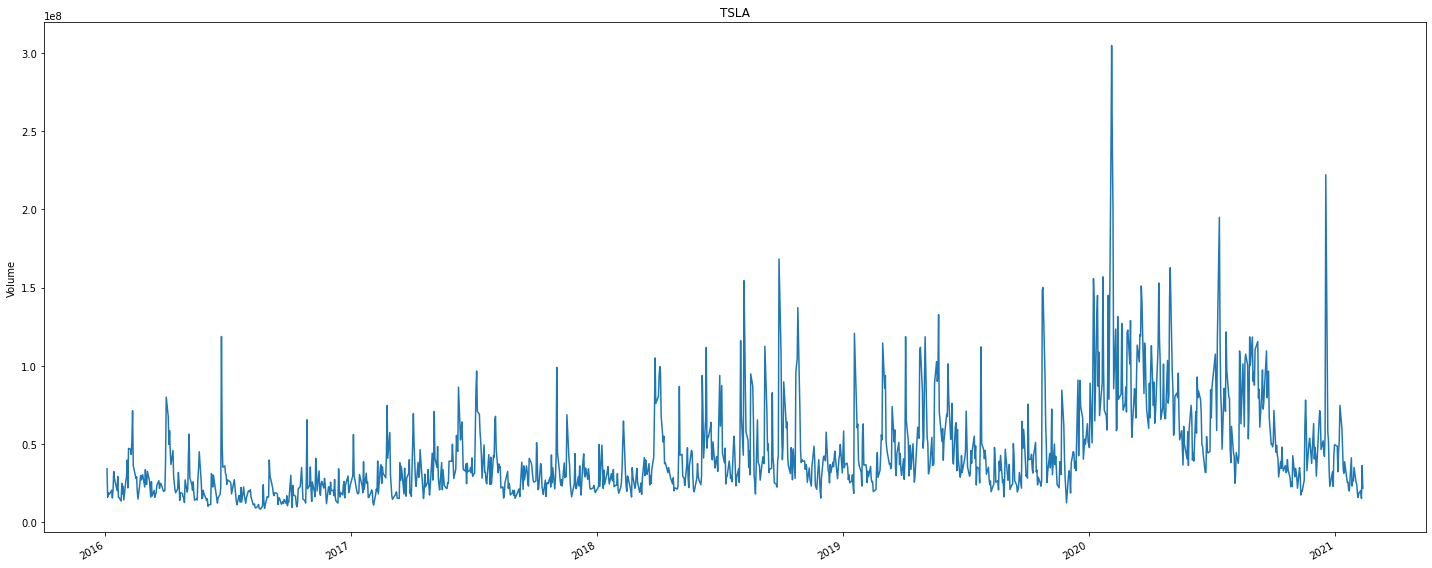

In [8]:
# For plotting the total volume of stock being traded each day
plt.figure(figsize=(20, 8))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('TSLA')
plt.tight_layout()

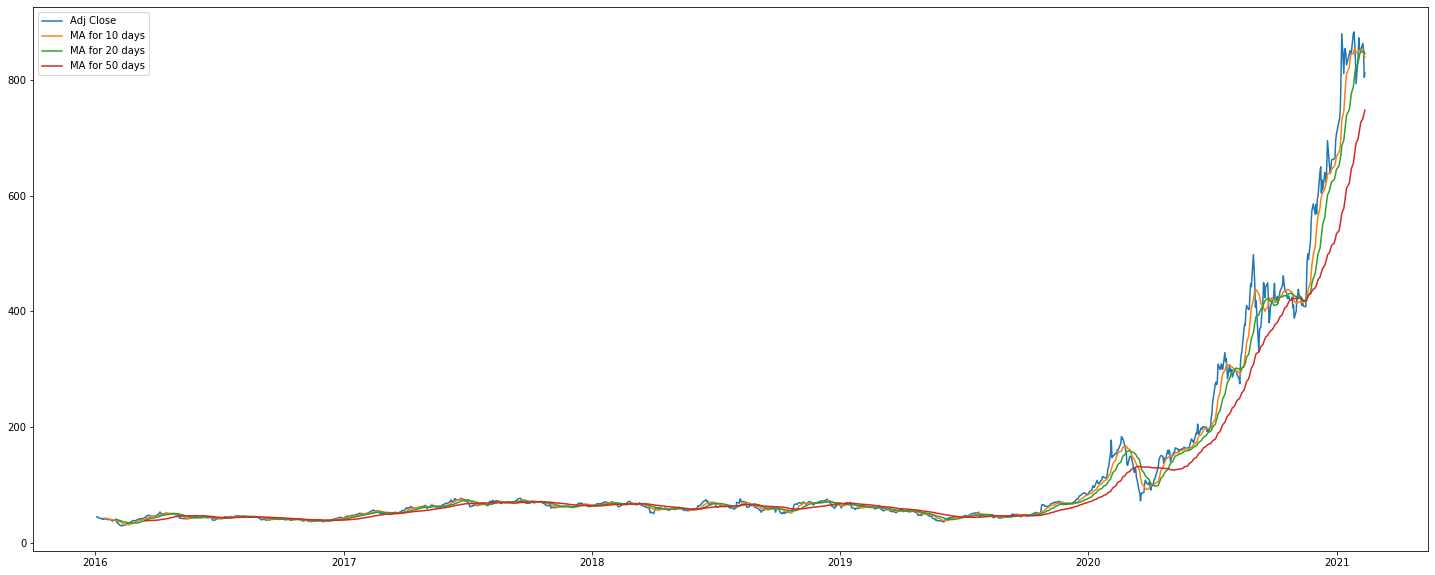

In [9]:
# Calculating Moving Average with lag of 10, 20, 50 days.
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f'MA for {ma} days'
    df[column_name] = df['Adj Close'].rolling(ma).mean()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Adj Close'], label= 'Adj Close')
ax.plot(df['MA for 10 days'], label='MA for 10 days')
ax.plot(df['MA for 20 days'], label='MA for 20 days')
ax.plot(df['MA for 50 days'], label='MA for 50 days')
ax.legend()
plt.show()

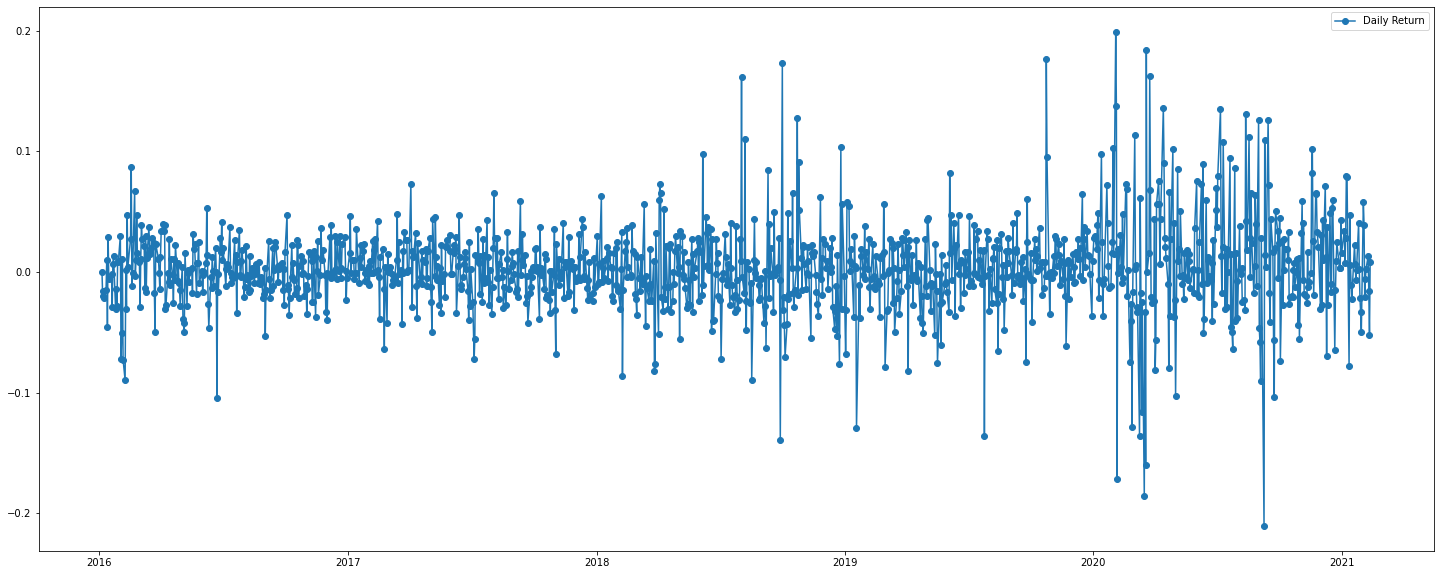

In [10]:
df['Daily Return'] = df['Adj Close'].pct_change()
    
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Daily Return'], label= 'Daily Return', linestyle='-', marker='o')
ax.legend()
plt.show()

### Test for stationary series

In [11]:
df = pd.read_csv(r'..\stocks\TSLA.csv', index_col=['Date'], parse_dates=['Date'])
# Drop NaNs
df = df.dropna()
# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').sum()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,63.026001,59.759998,61.220001,62.023998,58293000.0,62.023998
2019-01-03,61.880001,59.476002,61.400002,60.071999,34826000.0,60.071999
2019-01-04,63.599998,60.546001,61.200001,63.537998,36970500.0,63.537998
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2019-01-06,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


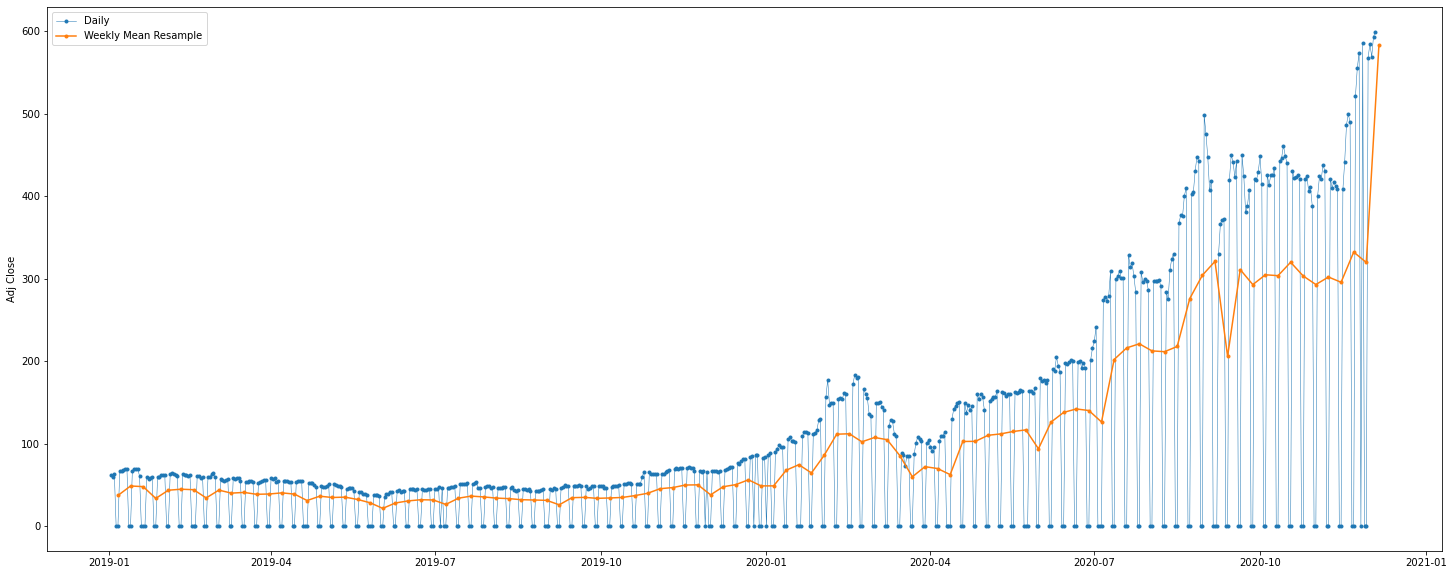

In [12]:
adj_close = df['Adj Close']
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(adj_close.resample('W').mean(),marker='o', markersize=3, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

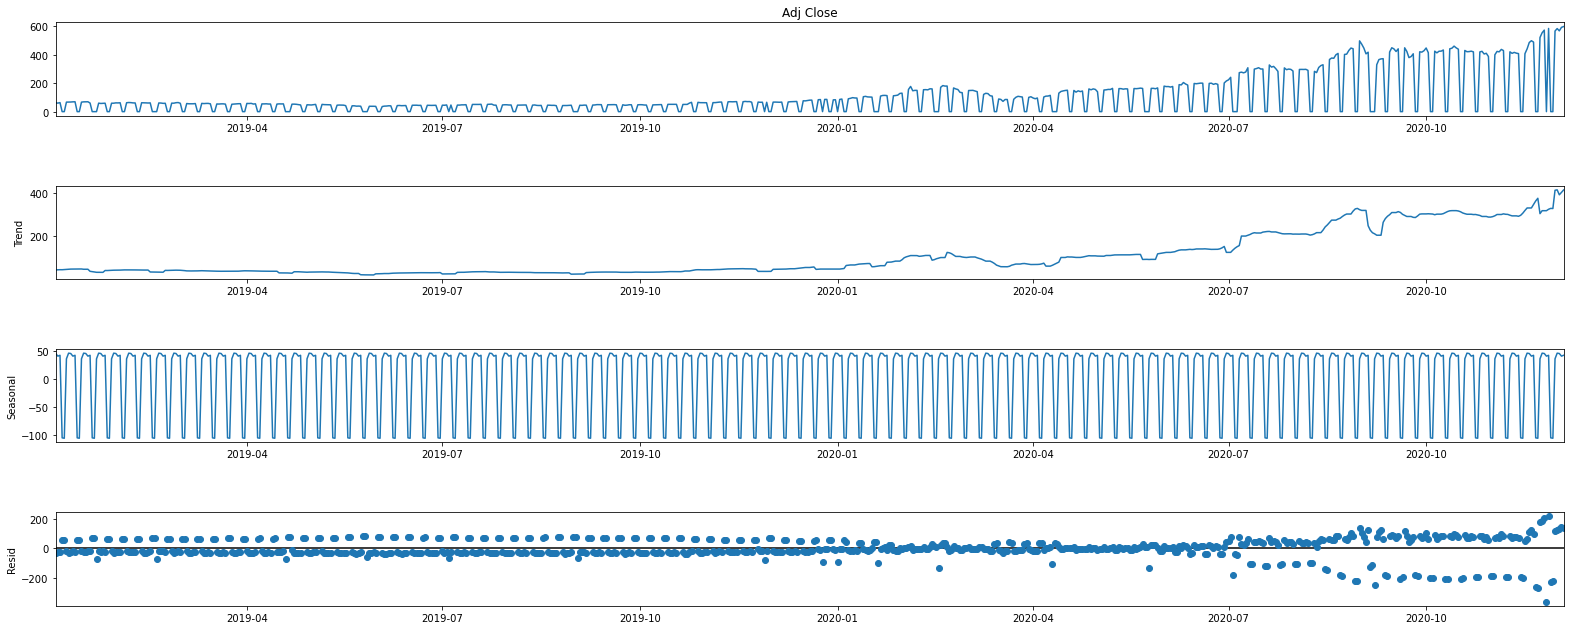

In [13]:
# graphs to show seasonal_decompose
def seasonal_decompose (adj_close):
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()
    
seasonal_decompose(adj_close)

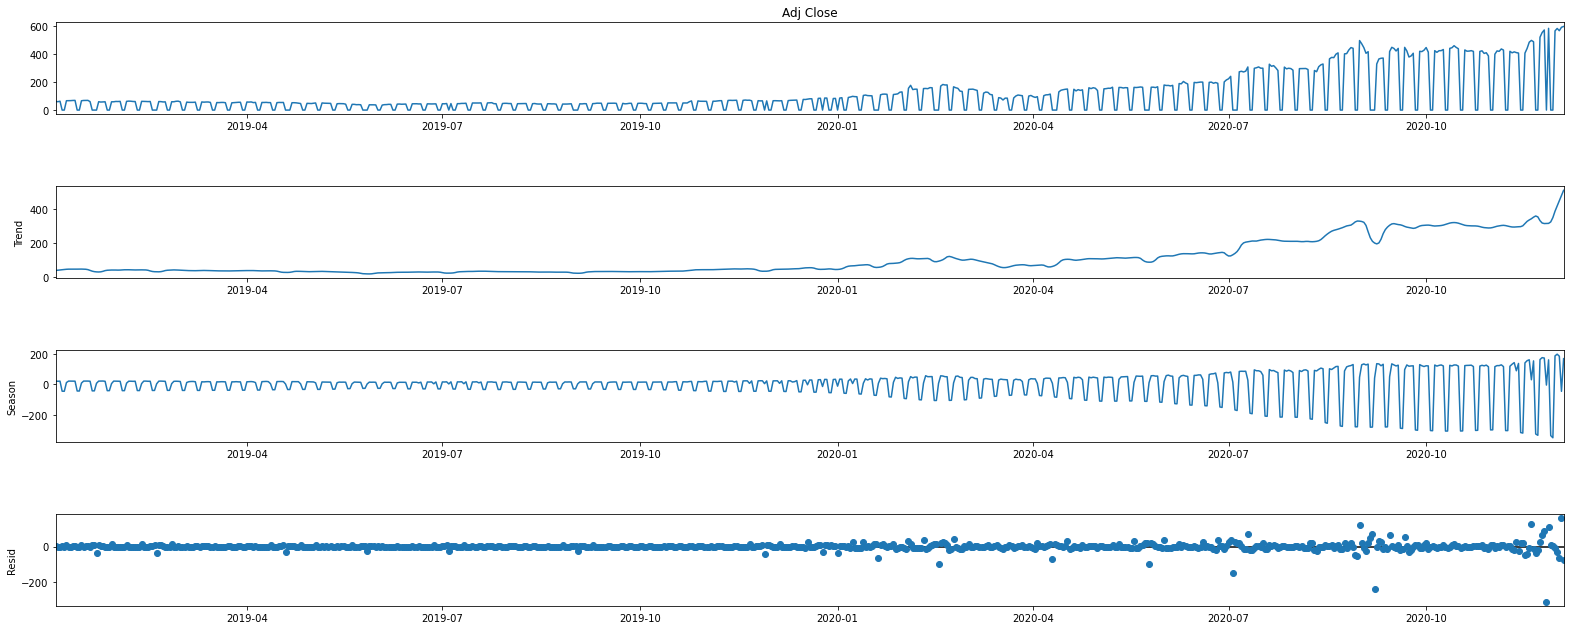

In [14]:
# graphs to show stl_decompose
def stl_decompose (adj_close):
    decomposition = STL(adj_close).fit()
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()

stl_decompose(adj_close)

### Check for Stationarity:

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

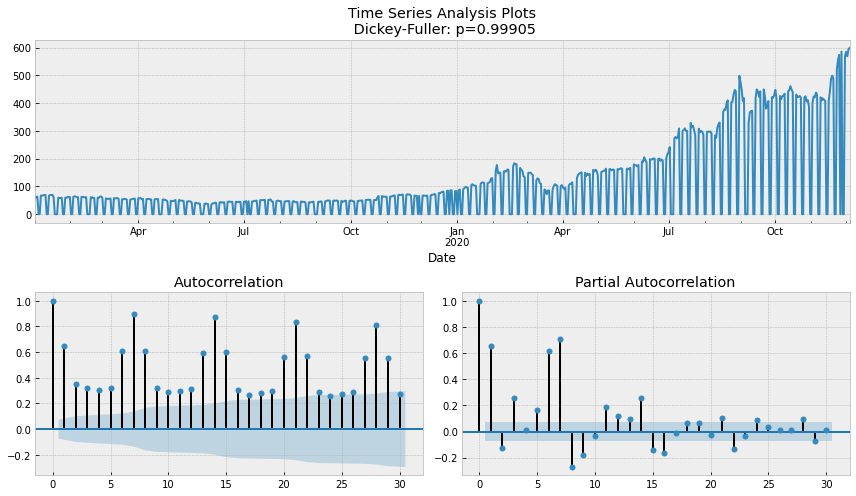

In [16]:
tsplot(df['Adj Close'], lags=30)

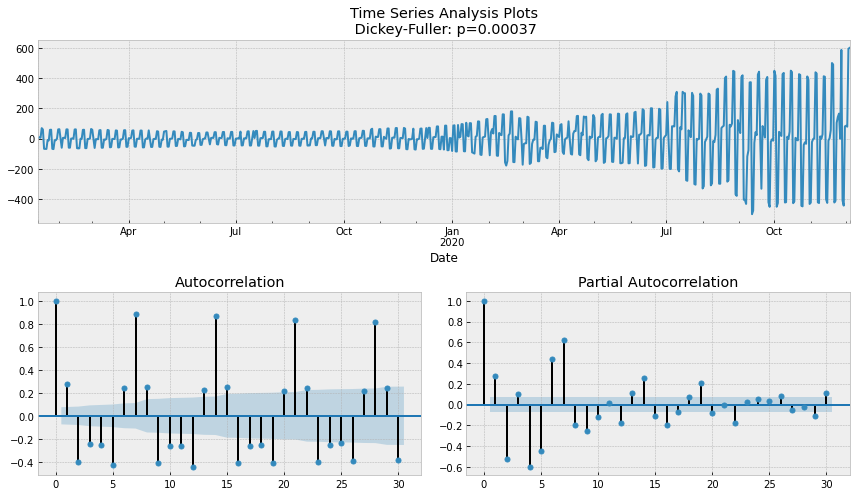

In [17]:
ads_diff = df['Adj Close'] - df['Adj Close'].shift(12)
tsplot(ads_diff[12:], lags=30)

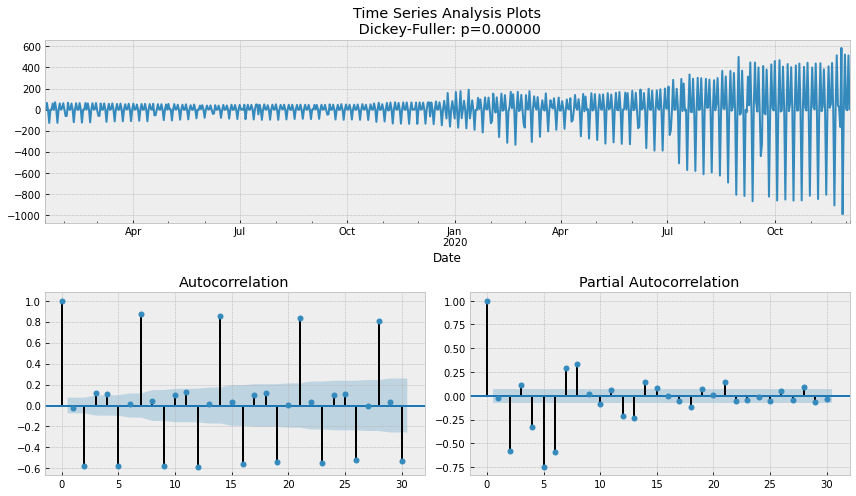

In [18]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[12+1:], lags=30)